In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate 120 days of defect data
np.random.seed(42)
days = pd.date_range(start="2020-01-01", periods=120)
sample_size = np.random.randint(80, 120, size=120)  # daily sample sizes

# Introduce a shift in the defect rate after 60 days
true_defect_rate = np.concatenate([np.full(60, 0.05), np.full(60, 0.085)])


# Simulate daily defect counts
defect_count = np.random.binomial(sample_size, true_defect_rate)

df = pd.DataFrame({
    'Date': days,
    'Sample_Size': sample_size,
    'Defects': defect_count
})

df['Defect_Rate'] = df['Defects'] / df['Sample_Size']
print(df.head())

        Date  Sample_Size  Defects  Defect_Rate
0 2020-01-01          118        7     0.059322
1 2020-01-02          108        3     0.027778
2 2020-01-03           94        4     0.042553
3 2020-01-04           87        3     0.034483
4 2020-01-05          100        8     0.080000


In [2]:
# Overall average defect rate (p̄)
p_bar = df['Defects'].sum() / df['Sample_Size'].sum()

# Control limits (3σ)
df['p_bar'] = p_bar
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample_Size'])
df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)  # LCL can't be negative

df.head()

,Date,Sample_Size,Defects,Defect_Rate,p_bar,UCL,LCL
0,2020-01-01,118,7,0.059322,0.070091,0.140599,0.0
1,2020-01-02,108,3,0.027778,0.070091,0.143791,0.0
2,2020-01-03,94,4,0.042553,0.070091,0.149088,0.0
3,2020-01-04,87,3,0.034483,0.070091,0.152205,0.0
4,2020-01-05,100,8,0.080000,0.070091,0.146682,0.0


In [3]:
# Add a shifted defect rate column
df['Shifted_Defect_Rate'] = df['Defect_Rate'].shift(75)

print(df.tail())

          Date  Sample_Size  Defects  Defect_Rate     p_bar       UCL  LCL  \
115 2020-04-25          105        8     0.076190  0.070091  0.144836  0.0   
116 2020-04-26           93       15     0.161290  0.070091  0.149512  0.0   
117 2020-04-27          118        7     0.059322  0.070091  0.140599  0.0   
118 2020-04-28          106        4     0.037736  0.070091  0.144483  0.0   
119 2020-04-29           88        7     0.079545  0.070091  0.151737  0.0   

     Shifted_Defect_Rate  
115             0.056818  
116             0.047619  
117             0.012346  
118             0.030303  
119             0.037383  


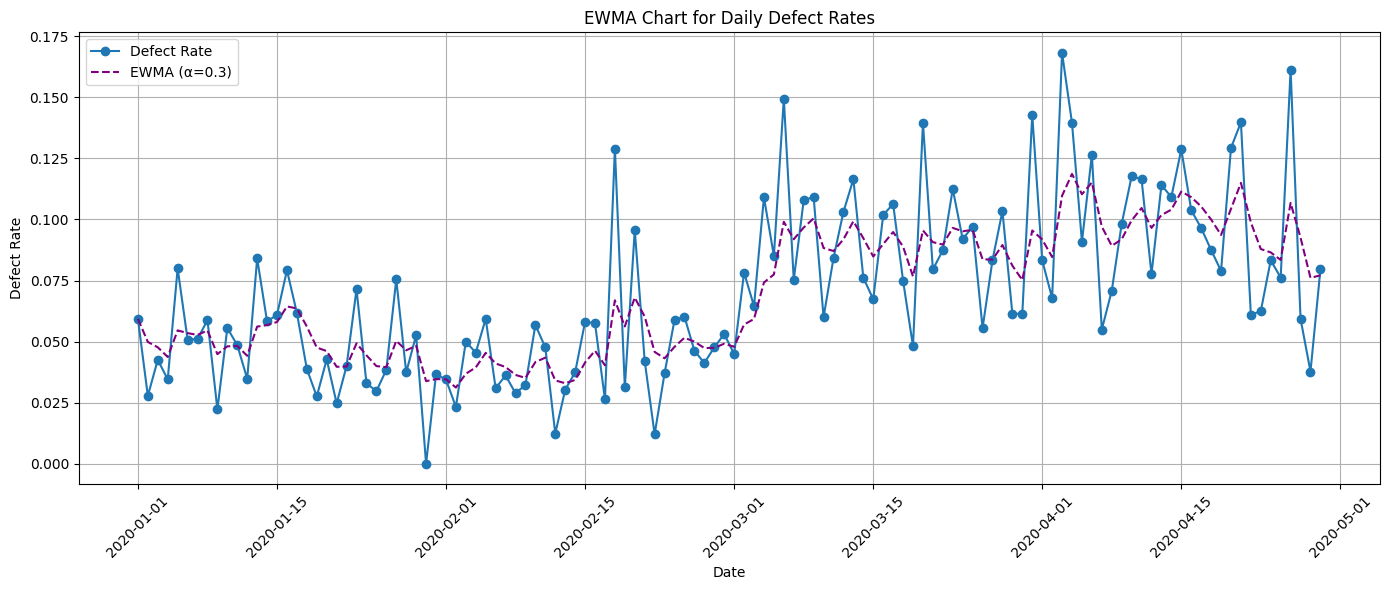

In [4]:
# Calculate and plot EWMA
df['EWMA'] = df['Defect_Rate'].ewm(alpha=0.3, adjust=False).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['EWMA'], linestyle='--', color='purple', label='EWMA (α=0.3)')
plt.title('EWMA Chart for Daily Defect Rates')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df['Out_of_Control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])

# Show flagged days
print(df[df['Out_of_Control']][['Date', 'Defect_Rate', 'UCL', 'LCL']])

          Date  Defect_Rate       UCL  LCL
90  2020-03-31     0.142857  0.142463  0.0
93  2020-04-03     0.168224  0.144134  0.0
116 2020-04-26     0.161290  0.149512  0.0


In [6]:
from statsmodels.stats.proportion import proportions_ztest

# Test if last day's defect rate is significantly higher than average
last = df.iloc[-1]
count = last['Defects']
nobs = last['Sample_Size']

stat, pval = proportions_ztest(count, nobs, value=p_bar, alternative='larger')
print(f"Z-stat: {stat:.2f}, p-value: {pval:.4f}")

if pval < 0.05:
    print("🔺 Statistically significant increase in defects")
else:
    print("✅ No significant shift detected.")


Z-stat: 0.33, p-value: 0.3715
✅ No significant shift detected.


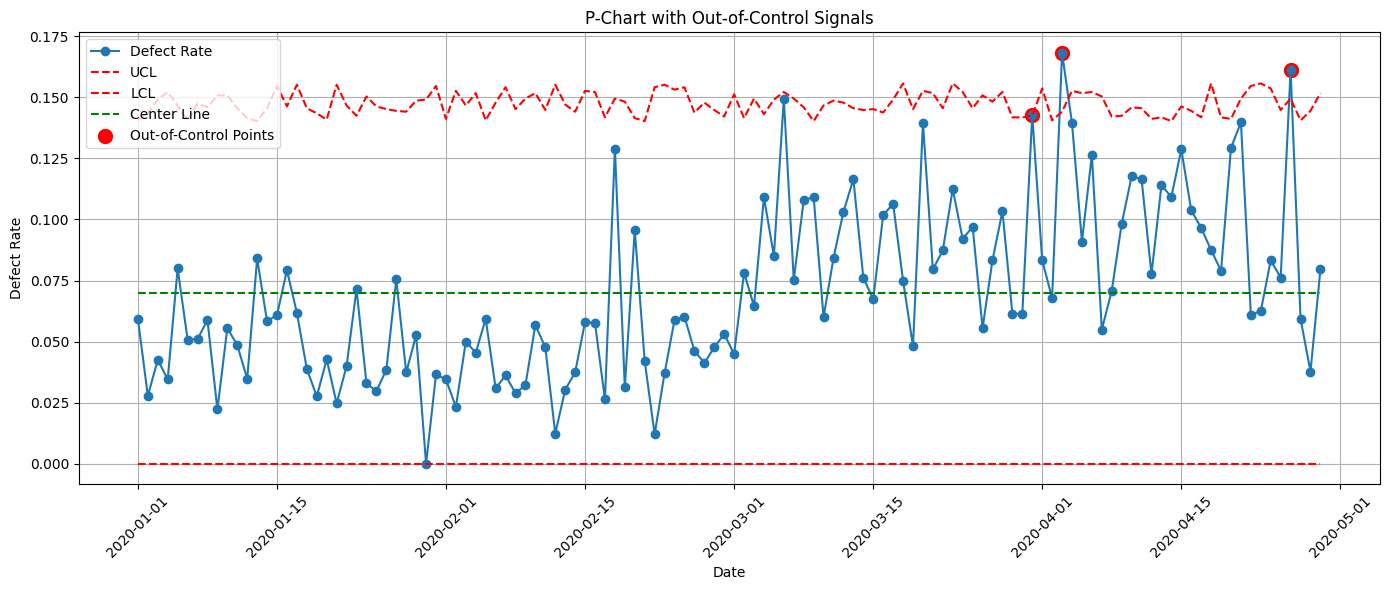

In [7]:
# Mark out-of-control points on the chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL')
plt.plot(df['Date'], df['p_bar'], linestyle='--', color='green', label='Center Line')

# Highlight points
out = df[df['Out_of_Control']]
plt.scatter(out['Date'], out['Defect_Rate'], color='red', s=100, label='Out-of-Control Points')

plt.title('P-Chart with Out-of-Control Signals')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Introduce a shift in the defect rate on day 35
df.loc[35:, 'Defects'] = np.random.binomial(df.loc[35:, 'Sample_Size'], 0.10)  # doubled defect rate
df['Defect_Rate'] = df['Defects'] / df['Sample_Size']

C:\Users\soumy\AppData\Local\Temp\ipykernel_28560\143636147.py:45: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\paidCourse\python\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


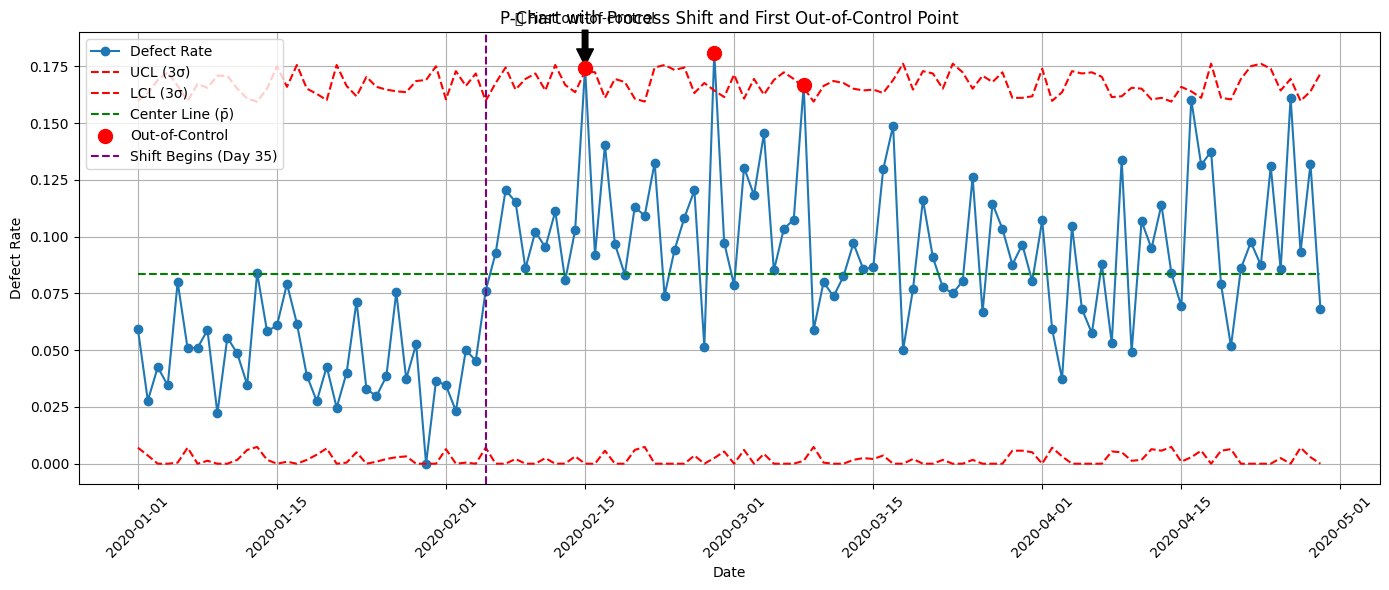

In [9]:
# Recalculate p̄ and control limits
p_bar = df['Defects'].sum() / df['Sample_Size'].sum()
df['p_bar'] = p_bar
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample_Size'])
df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)

# Flag out-of-control points
df['Out_of_Control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])
out_points = df[df['Out_of_Control']]

# Identify first out-of-control point AFTER the shift
first_shift_index = 35
first_out_after_shift = df.loc[first_shift_index:].query("Out_of_Control").head(1)

# Plot setup
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='--', color='green', label='Center Line (p̄)')
plt.scatter(out_points['Date'], out_points['Defect_Rate'], color='red', s=100, zorder=5, label='Out-of-Control')
plt.axvline(df['Date'].iloc[first_shift_index], color='purple', linestyle='--', label='Shift Begins (Day 35)')

# Add annotation to first out-of-control point after shift
if not first_out_after_shift.empty:
    x = first_out_after_shift['Date'].values[0]
    y = first_out_after_shift['Defect_Rate'].values[0]
    plt.annotate(
        '🔺 First out-of-control',
        xy=(x, y),
        xytext=(x, y + 0.02),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=10,
        ha='center'
    )

# Labels and Layout
plt.title('P-Chart with Process Shift and First Out-of-Control Point')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np

# Step 1: Estimate standard deviation for each row
df['sigma'] = np.sqrt((df['p_bar'] * (1 - df['p_bar'])) / df['Sample_Size'])

# Step 2: Compute 1σ and 2σ boundaries
df['Upper_1sigma'] = df['p_bar'] + df['sigma']
df['Lower_1sigma'] = df['p_bar'] - df['sigma']
df['Upper_2sigma'] = df['p_bar'] + 2 * df['sigma']
df['Lower_2sigma'] = df['p_bar'] - 2 * df['sigma']

# ------------------------------------------------------------------

# RULE 1: One point beyond UCL or LCL
df['Rule1'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])

# ------------------------------------------------------------------

# RULE 2: 2 of 3 consecutive points beyond 2σ (same side)
rule2_flags = [False] * len(df)
for i in range(2, len(df)):
    upper = (df.loc[i-2:i, 'Defect_Rate'] > df.loc[i-2:i, 'Upper_2sigma']).sum()
    lower = (df.loc[i-2:i, 'Defect_Rate'] < df.loc[i-2:i, 'Lower_2sigma']).sum()
    rule2_flags[i] = (upper >= 2) or (lower >= 2)
df['Rule2'] = rule2_flags

# ------------------------------------------------------------------

# RULE 4: 8 points in a row on same side of center line
df['Above_Center'] = df['Defect_Rate'] > df['p_bar']
run_lengths = [1]
for i in range(1, len(df)):
    if df.loc[i, 'Above_Center'] == df.loc[i - 1, 'Above_Center']:
        run_lengths.append(run_lengths[-1] + 1)
    else:
        run_lengths.append(1)
df['Run_Length'] = run_lengths
df['Rule4'] = df['Run_Length'] >= 8

# ------------------------------------------------------------------

# Combine rules
df['Any_Rule_Violation'] = df[['Rule1', 'Rule2', 'Rule4']].any(axis=1)

# view violations
violations =df[df['Any_Rule_Violation']]
print(violations[['Date', 'Defect_Rate', 'Rule1', 'Rule2', 'Rule4']])

          Date  Defect_Rate  Rule1  Rule2  Rule4
7   2020-01-08     0.058824  False  False   True
8   2020-01-09     0.022222  False  False   True
9   2020-01-10     0.055556  False  False   True
10  2020-01-11     0.048544  False  False   True
11  2020-01-12     0.034783  False  False   True
20  2020-01-21     0.024691  False  False   True
21  2020-01-22     0.040000  False  False   True
22  2020-01-23     0.071429  False  False   True
23  2020-01-24     0.032967  False  False   True
24  2020-01-25     0.029703  False  False   True
25  2020-01-26     0.038462  False  False   True
26  2020-01-27     0.075472  False  False   True
27  2020-01-28     0.037383  False  False   True
28  2020-01-29     0.052632  False  False   True
29  2020-01-30     0.000000  False  False   True
30  2020-01-31     0.036585  False  False   True
31  2020-02-01     0.034483  False  False   True
32  2020-02-02     0.023256  False  False   True
33  2020-02-03     0.050000  False  False   True
34  2020-02-04     0

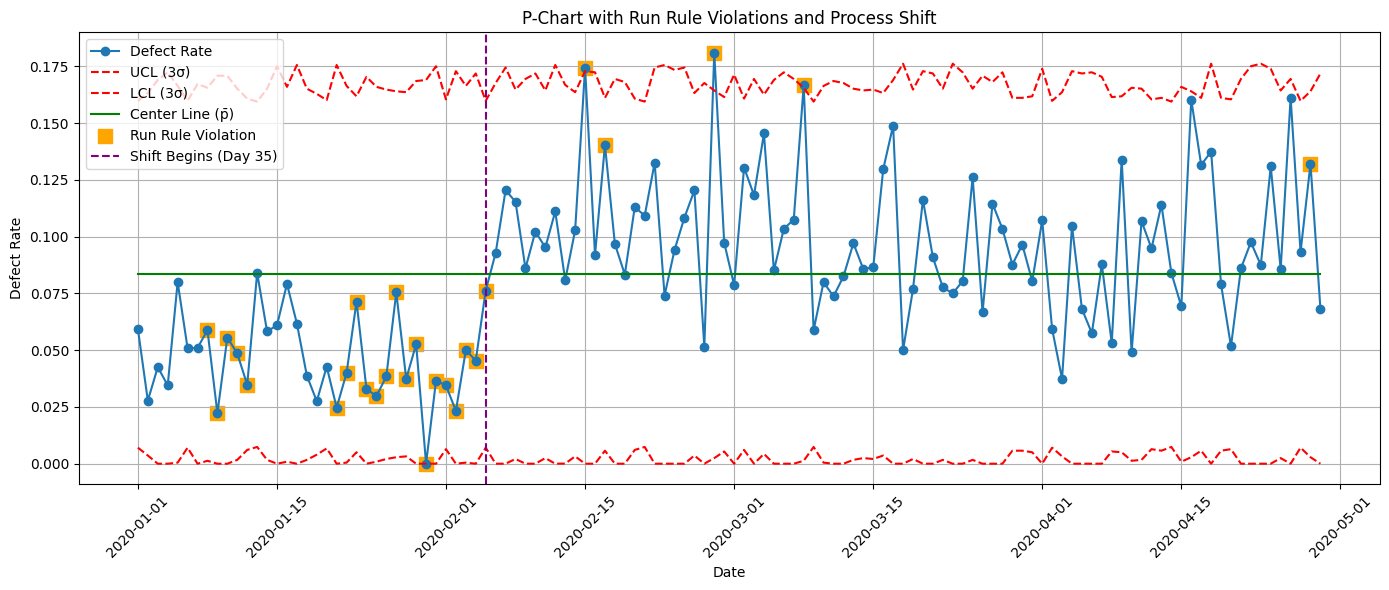

In [11]:
# Plot with violations highlighted
plt.figure(figsize=(14, 6))

# Main defect rate line
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')

# Control Limits and center
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

# Highlight violations
violations = df[df['Any_Rule_Violation']]
plt.scatter(violations['Date'], violations['Defect_Rate'],
            color='orange', s=100, marker='s', label='Run Rule Violation')

# Add shift marker
plt.axvline(df['Date'].iloc[35], color='purple', linestyle='--', label='Shift Begins (Day 35)')

# Final touches
plt.title('P-Chart with Run Rule Violations and Process Shift')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Assume specs: acceptable defect rate between 2% and 8%
USL, LSL = 0.08, 0.02
process_sigma = df['Defect_Rate'].std()

Cp = (USL - LSL) / (6 * process_sigma)
Cpk = min(USL - p_bar, p_bar - LSL) / (3 * process_sigma)

print(f"Cp: {Cp:.2f}, Cpk: {Cpk:.2f}")


Cp: 0.28, Cpk: -0.03


In [13]:
boot_means = [np.mean(np.random.choice(df['Defect_Rate'], size=len(df), replace=True)) for _ in range(1000)]
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"95% CI for average defect rate: ({ci_lower:.4f}, {ci_upper:.4f})")

95% CI for average defect rate: (0.0771, 0.0899)


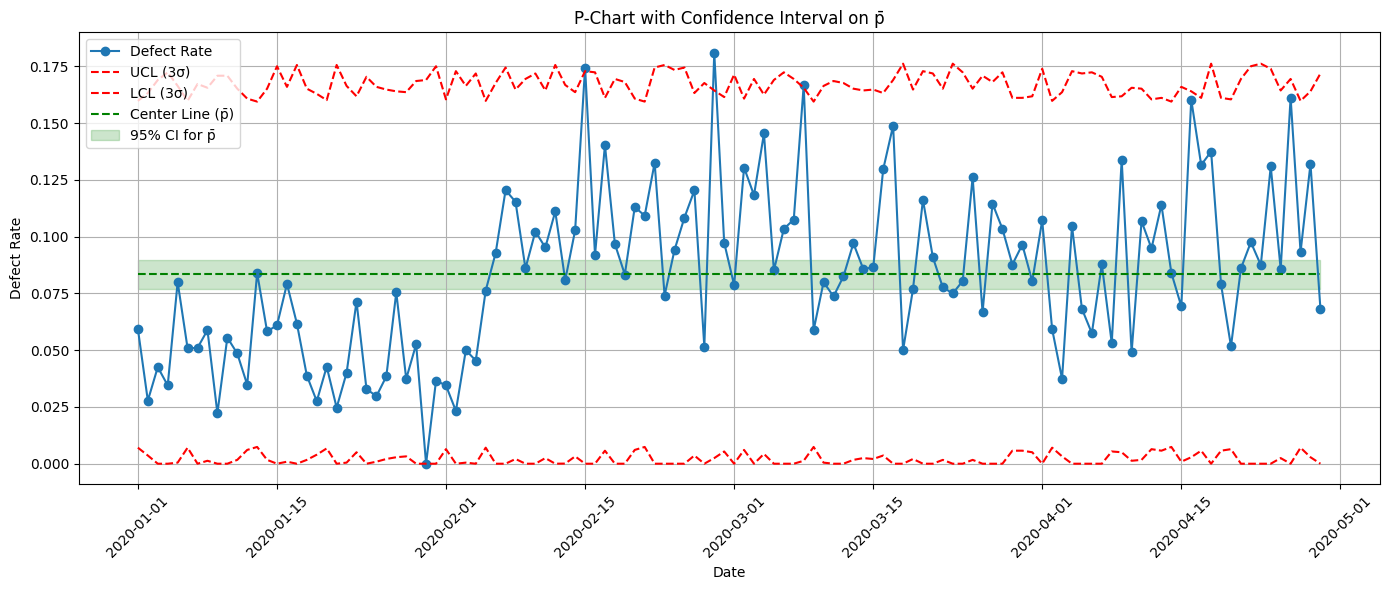

In [14]:
# Existing chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='--', color='green', label='Center Line (p̄)')

# Add this for confidence interval shading
plt.fill_between(
    df['Date'], ci_lower, ci_upper,
    color='green', alpha=0.2, label='95% CI for p̄'
)

# Finalize chart
plt.title('P-Chart with Confidence Interval on p̄')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

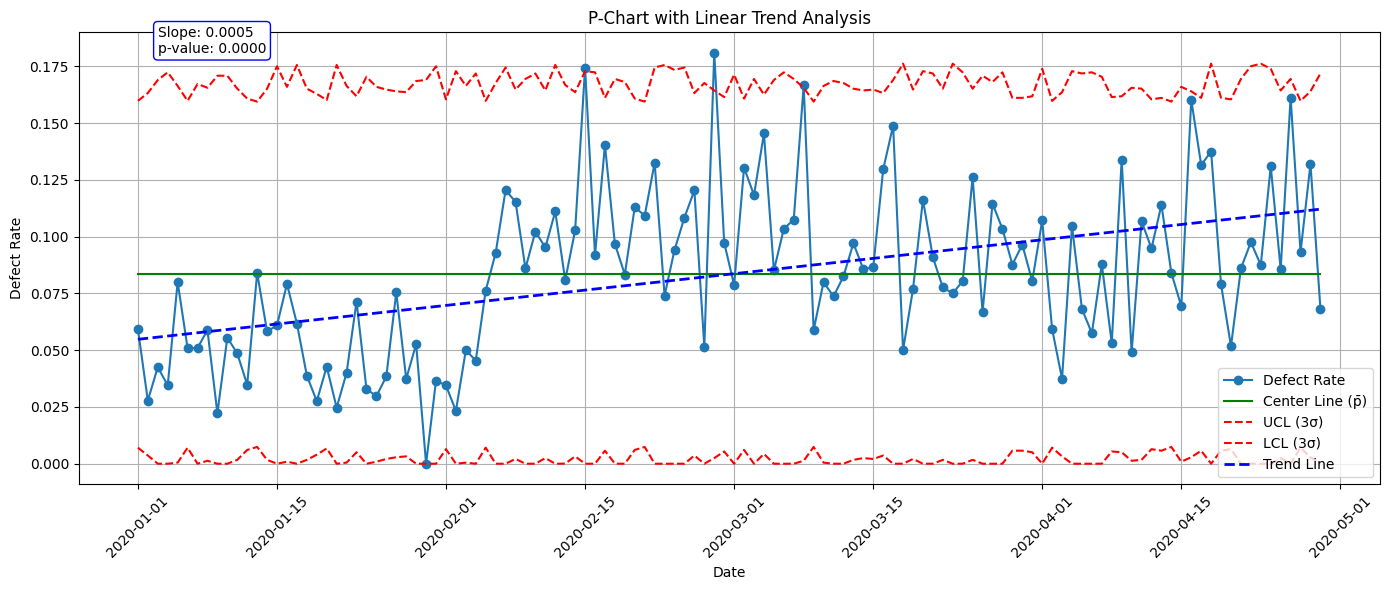

In [15]:
from scipy.stats import linregress

# Step 1: Create a numeric “Day” column
df['Day'] = range(1, len(df) + 1)

# Step 2: Run linear regression on defect rate over time
trend_result = linregress(df['Day'], df['Defect_Rate'])

slope = trend_result.slope
p_value = trend_result.pvalue
intercept = trend_result.intercept

# Step 3: Create trend line values
df['Trend_Line'] = intercept + slope * df['Day']

# Step 4: Plot p-chart with trend line
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')

# Add trend line
plt.plot(df['Date'], df['Trend_Line'], linestyle='--', color='blue', linewidth=2, label='Trend Line')

# Step 5: Annotate with slope and p-value
plt.text(df['Date'].iloc[2], max(df['Defect_Rate']),
         f"Slope: {slope:.4f}\np-value: {p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))

# Final touches
plt.title('P-Chart with Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

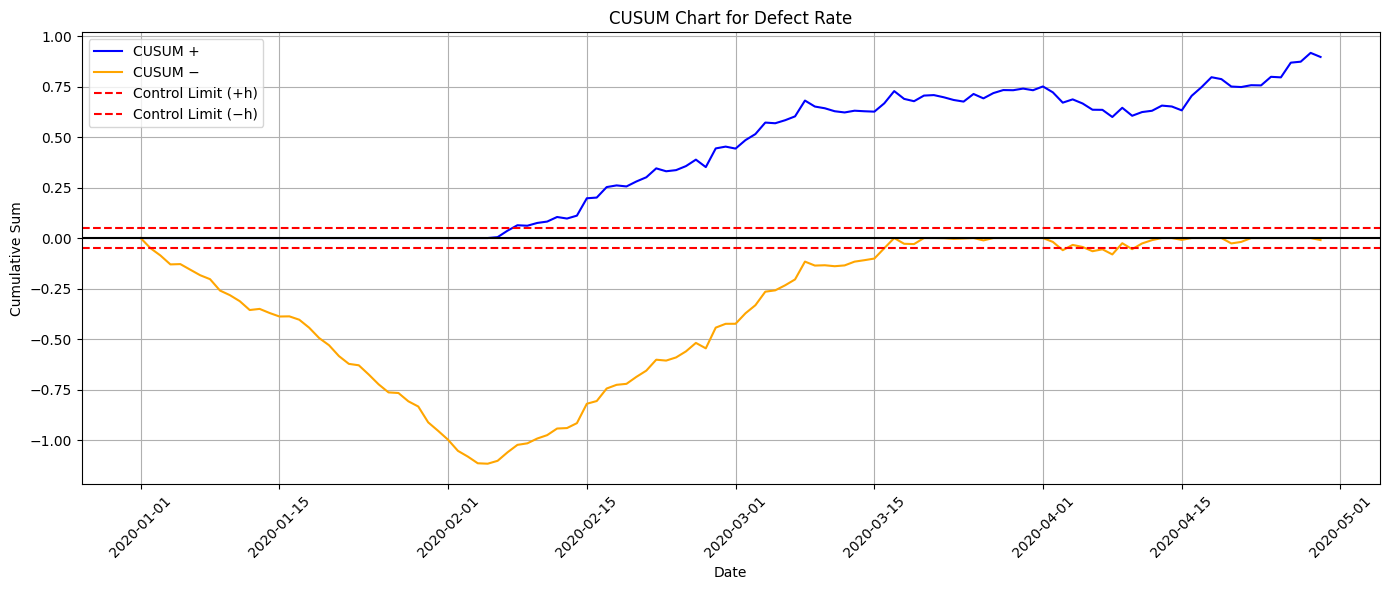

In [16]:
# CUSUM parameters
target = df['Defect_Rate'].mean()  # p̄
k = 0.005  # Reference value (tuning sensitivity)
h = 0.05   # Decision threshold

# Initialize Lists
cusum_pos = [0]
cusum_neg = [0]

# Calculate CUSUM values
for i in range(1, len(df)):
    p_i = df.loc[i, 'Defect_Rate']
    s_pos = max(0, cusum_pos[-1] + (p_i - target - k))
    s_neg = min(0, cusum_neg[-1] + (p_i - target + k))
    cusum_pos.append(s_pos)
    cusum_neg.append(s_neg)

# Add to DataFrame
df['CUSUM_Pos'] = cusum_pos
df['CUSUM_Neg'] = cusum_neg

# Plot CUSUM
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
plt.plot(df['Date'], df['CUSUM_Neg'], label='CUSUM −', color='orange')

plt.axhline(h, color='red', linestyle='--', label='Control Limit (+h)')
plt.axhline(-h, color='red', linestyle='--', label='Control Limit (−h)')
plt.axhline(0, color='black', linestyle='-')

plt.title('CUSUM Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

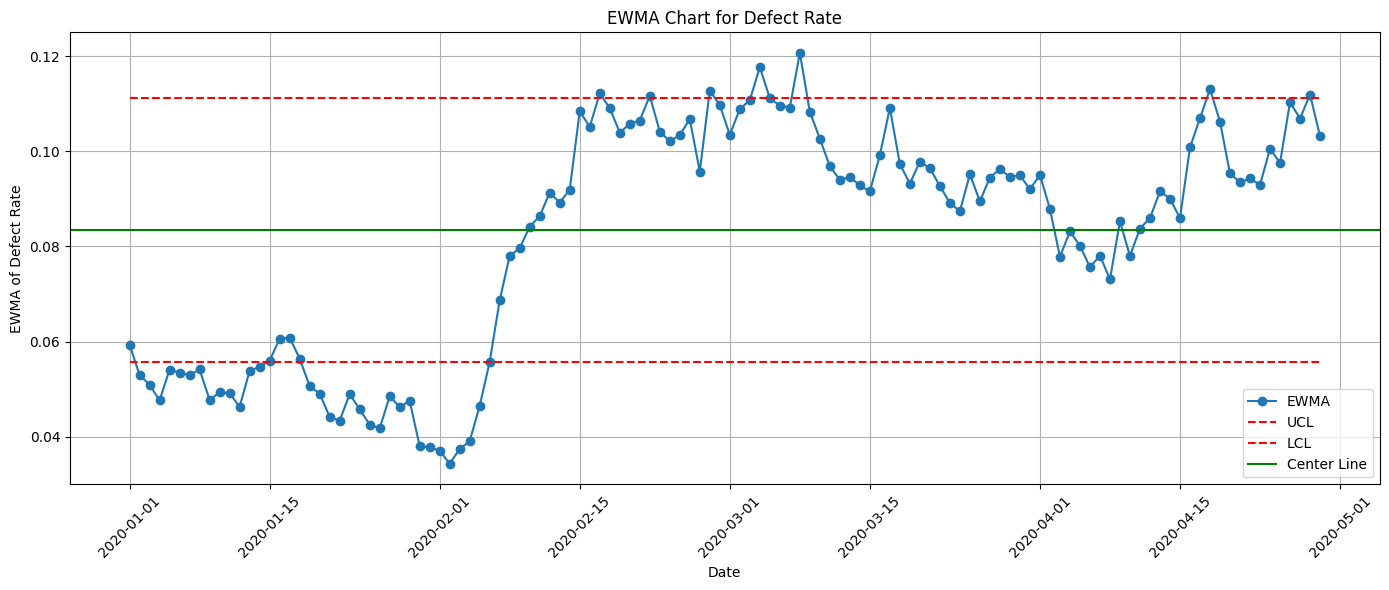

In [17]:
# EWMA parameters
lambda_ = 0.2  # Smoothing constant (0.1–0.3 common)
L = 3          # Control limit multiplier

# Initialize EWMA
df['EWMA'] = 0.0
df.loc[0, 'EWMA'] = df.loc[0, 'Defect_Rate']

# Compute EWMA for each day
for i in range(1, len(df)):
    df.loc[i, 'EWMA'] = lambda_ * df.loc[i, 'Defect_Rate'] + (1 - lambda_) * df.loc[i - 1, 'EWMA']

# Estimate sigma (average over entire series)
p_bar = df['Defect_Rate'].mean()
avg_n = df['Sample_Size'].mean()
sigma = np.sqrt((p_bar * (1 - p_bar)) / avg_n)

# Control Limits
df['UCL_EWMA'] = p_bar + L * sigma * np.sqrt(lambda_ / (2 - lambda_))
df['LCL_EWMA'] = p_bar - L * sigma * np.sqrt(lambda_ / (2 - lambda_))

# Plot EWMA
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['EWMA'], marker='o', label='EWMA')
plt.plot(df['Date'], df['UCL_EWMA'], linestyle='--', color='red', label='UCL')
plt.plot(df['Date'], df['LCL_EWMA'], linestyle='--', color='red', label='LCL')
plt.axhline(p_bar, color='green', linestyle='-', label='Center Line')
plt.title('EWMA Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\soumy\AppData\Local\Temp\ipykernel_28560\704006735.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\soumy\AppData\Local\Temp\ipykernel_28560\704006735.py:60: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\soumy\AppData\Local\Temp\ipykernel_28560\704006735.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
d:\paidCourse\python\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
d:\paidCourse\python\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
d:\paidCourse\python\venv\Lib\site-packages

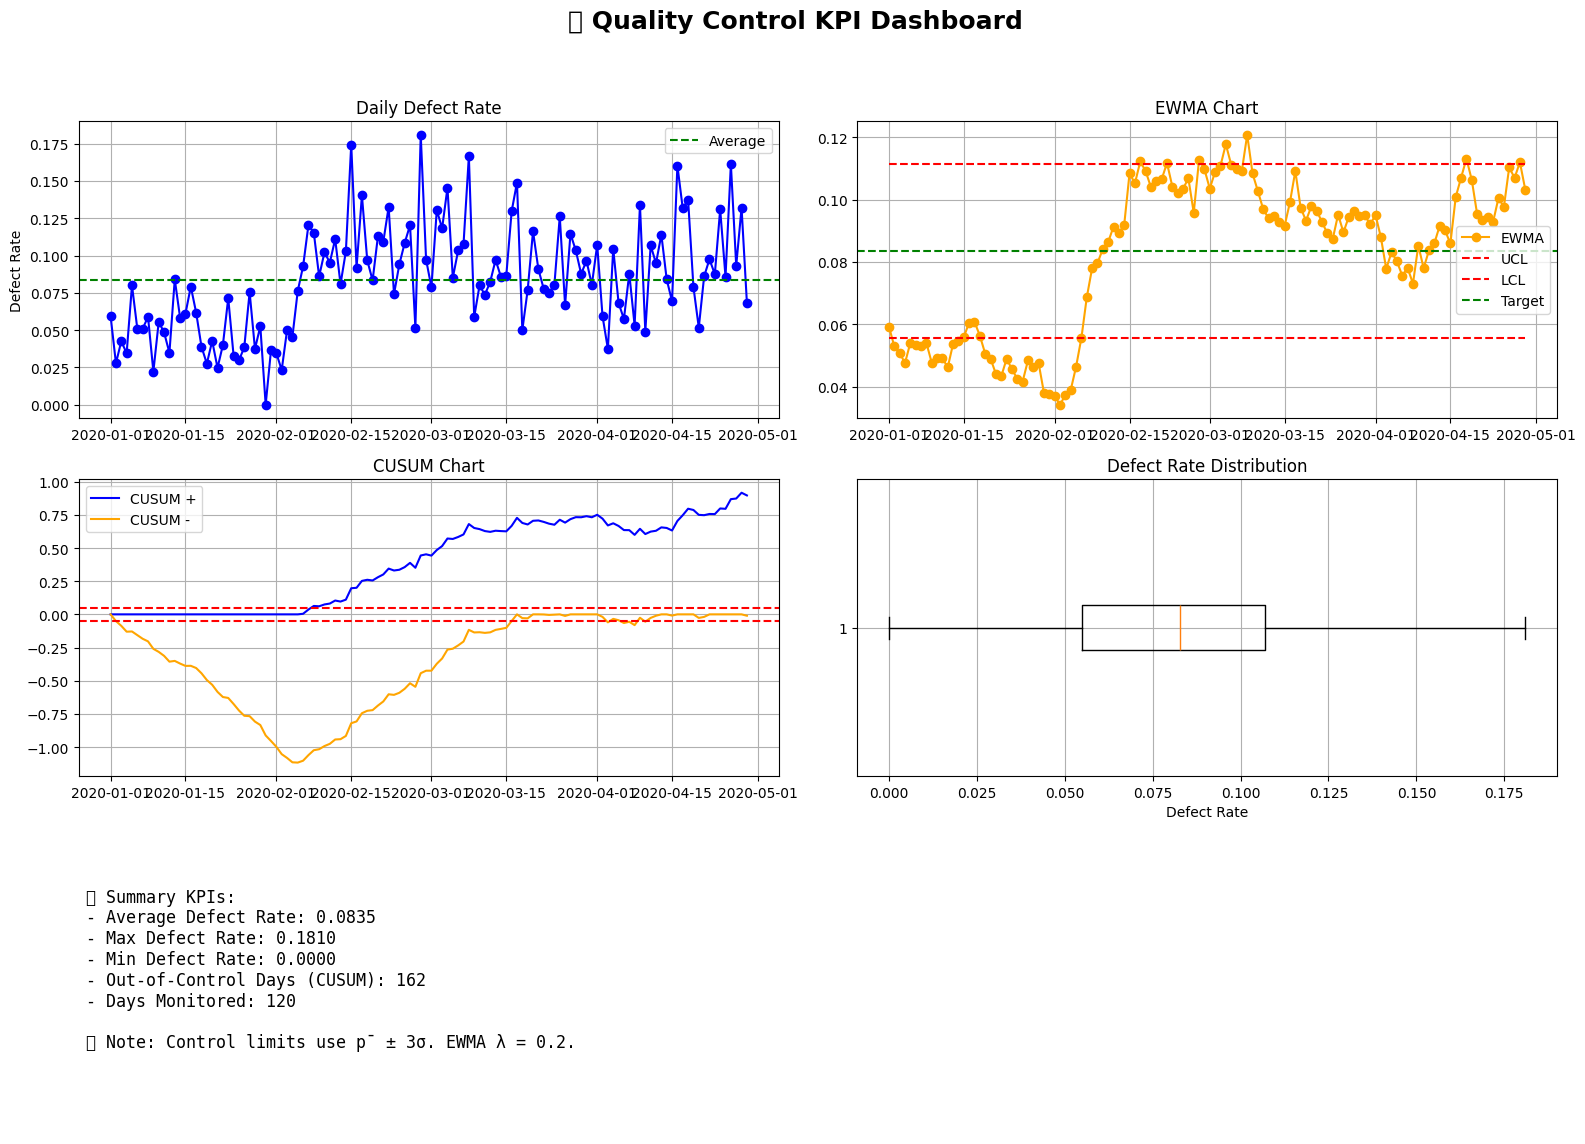

In [18]:
# Recalculate needed KPIs
avg_defect_rate = df['Defect_Rate'].mean()
max_defect_rate = df['Defect_Rate'].max()
min_defect_rate = df['Defect_Rate'].min()
out_of_control_days = (df['CUSUM_Pos'] > 0.05).sum() + (df['CUSUM_Neg'] < -0.05).sum()

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('📊 Quality Control KPI Dashboard', fontsize=18, fontweight='bold')

# 1. Daily Defect Rate
axs[0, 0].plot(df['Date'], df['Defect_Rate'], marker='o', color='blue')
axs[0, 0].axhline(avg_defect_rate, color='green', linestyle='--', label='Average')
axs[0, 0].set_title('Daily Defect Rate')
axs[0, 0].set_ylabel('Defect Rate')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. EWMA Chart
axs[0, 1].plot(df['Date'], df['EWMA'], marker='o', label='EWMA', color='orange')
axs[0, 1].plot(df['Date'], df['UCL_EWMA'], linestyle='--', color='red', label='UCL')
axs[0, 1].plot(df['Date'], df['LCL_EWMA'], linestyle='--', color='red', label='LCL')
axs[0, 1].axhline(avg_defect_rate, color='green', linestyle='--', label='Target')
axs[0, 1].set_title('EWMA Chart')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. CUSUM Chart
axs[1, 0].plot(df['Date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
axs[1, 0].plot(df['Date'], df['CUSUM_Neg'], label='CUSUM -', color='orange')
axs[1, 0].axhline(0.05, color='red', linestyle='--')
axs[1, 0].axhline(-0.05, color='red', linestyle='--')
axs[1, 0].set_title('CUSUM Chart')
axs[1, 0].grid(True)
axs[1, 0].legend()

# 4. Boxplot of Defect Rates
axs[1, 1].boxplot(df['Defect_Rate'], vert=False)
axs[1, 1].set_title('Defect Rate Distribution')
axs[1, 1].set_xlabel('Defect Rate')
axs[1, 1].grid(True)

# 5. KPI Summary
axs[2, 0].axis('off')
kpi_text = f"""
📌 Summary KPIs:
- Average Defect Rate: {avg_defect_rate:.4f}
- Max Defect Rate: {max_defect_rate:.4f}
- Min Defect Rate: {min_defect_rate:.4f}
- Out-of-Control Days (CUSUM): {out_of_control_days}
- Days Monitored: {len(df)}

🧠 Note: Control limits use p̄ ± 3σ. EWMA λ = 0.2.
"""
axs[2, 0].text(0.01, 0.9, kpi_text, fontsize=12, verticalalignment='top', family='monospace')

# 6. Empty space for more content
axs[2, 1].axis('off')  # Placeholder for future KPI

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
